# Training Scan Model 

## Brief about SCAN algorithm: Its divided into 3 parts. 
  1. pretext model : Trained by running the simclr.py 
  2. scan model : Trained by running the scan.py 
  3. Selflabel model : This is the same model used in the stage 2. We only fine tune the scan output here. This stage is optional. 
  
 to learn more abt the algorithm read the getting started notebook in the SCAN folder. 


## Different Sections

1. **Creating dataset.**  
   we need 2 folders one containing jpeg images and the other containing tiff images.  The model is trained on the jpeg images and the tiff images are used to obtain the x,y cordinates. 

2. Calculating the mean and std for the kenya dataset. 
    
    (**step 1 and 2 need to run only once**)


3. Training the pretext part 

4. Plot the clusters using pretext model + Kmeans : (this part is optional)

5. Train the scan model 

6. Train the selflabel model: (optional)  The output of scan and self-label is the same hence the code in step 7 stays same.

7. Final Step : mapping clusters to classes.
    1. cluster plots : plotting images belonging to each cluster.
    2. cluster csv files : (lat,lan) vals of each cluster.
    3. cluster Histograms. 


## Outputs to trained models: 
  1. pretext model : output dim (256) user defined. 
  2. scan and self-label : Vector of dim C (where C = no. clusters)



## Important Tips:

  At the end of training the pretext model produces topK-train_neighbours and topk-val_neighbours this are used as inputs to the scan along with the weigths of the pretext model. 








New:  In this note the SCAN algorithm will be trained for 6 clusters and on custom mean and std and custom augmentation

Final Augmentatios 

1. RandomCropResize : Scale first the ratio then resize 
2. CollorJitter : Brightness : [0.5,2] , contrast : [2,7] rest 0 
3. Horizontal Flip 

4. Vertical Flip 

5. Normalize with cusotm mean and std


Experiment : 
1. simclr : 
  a. dim : 256 
  b. neineighbours : 7  : 
3. scan : entropy_weight : 7




In [ ]:
!nvidia-smi

Sat Dec 26 12:19:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Omdena/Unsupervised\ Methods/Unsupervised-Classification/SCAN
# !ls -lh

/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN


In [ ]:
!pip install -q pyyaml easydict                 # For using config files
!pip install -q termcolor   
!pip install -q faiss-gpu
!pip install -q rasterio

     |████████████████████████████████| 67.7MB 48kB/s 
     |████████████████████████████████| 18.3MB 176kB/s 


In [ ]:
import os 
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show 

# Part 1 : Creating dataset. 

Create two folders named kenya_jpeg and kenya_tiff 



In [ ]:
#apath to kenya dataset 
# before_img_path = Path('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before/')
# before_img_path


PosixPath('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before')

In [ ]:
# the tiff images are 16bit but we can only visualize 8bit in matplotlib hence we need to rescale the values 
# to do this will be using normMinMax function.
def normMinMax(x):

  return ((x - x.min()) / (x.max() - x.min()) * 255).astype(int)


In [ ]:
# ## read images from before path normalize them and store them in images.

# images = []
# for root,_,img_names in os.walk(before_img_path):

#     for img in img_names: 

#         path = os.path.join(root,img)
#         tiff_image = rio.open(path).read([4,3,2])

#         images.append(normMinMax(tiff_image))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


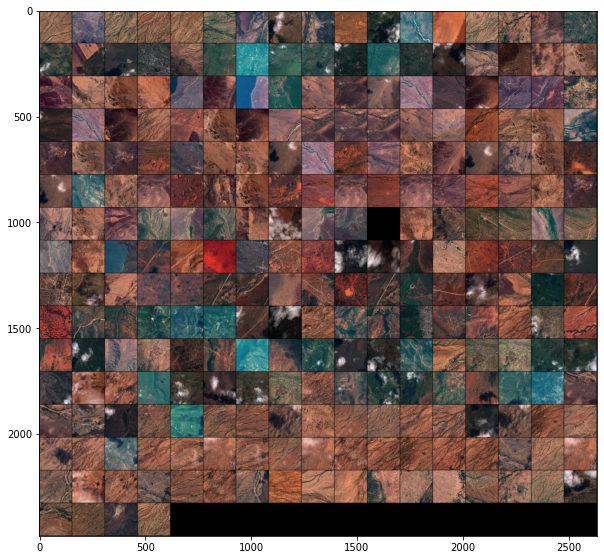

In [ ]:
# import torch
# from torchvision.utils import make_grid


# grid = make_grid(torch.tensor(images),nrow = 17)

# plt.figure(figsize=(10,10))
# plt.imshow(np.transpose(grid,(1,2,0)))


In [ ]:
#saving images in kenya_jpeg folder 

# folder = 'kenya_jepg/'


# for i,img in enumerate(images):
#     plt.imsave(folder + f'images_{i}.jpeg',img.transpose(1,2,0).astype('uint8'))



In [ ]:
#do the same for tiff images.


# folder = 'kenya_tiff/'

# for root,_,img_names in os.walk(before_img_path):

#     for img in img_names: 

#         path = os.path.join(root,img)
#         tiff_image = rio.open(path).read([4,3,2])

          # plt.imsave(folder + f'images_{i}.tiff',tiff_image)



# Part 2 : Calculating Mean and Std

In [ ]:
# from data.kenyaDataset import KenyaDataset 
# from torchvision.transforms import Compose,ToTensor


# transform = Compose([ToTensor()])


# dataset = KenyaDataset('kenya_jpeg/',transform = transform )


# total_pix = len(dataset) * 153 * 153

# mean = {'red':0,'green':0,'blue':0}
# std =  {'red':0,'green':0,'blue':0}

# for i in range(259):

#     data = dataset[i]['image']
#     mean['red'] += data[0,:,:].sum()
#     mean['green'] += data[1,:,:].sum()
#     mean['blue'] += data[2,:,:].sum()


# mean['red'] /= total_pix
# mean['green'] /= total_pix
# mean['blue'] /= total_pix

In [ ]:
mean

{'blue': tensor(0.2831), 'green': tensor(0.3090), 'red': tensor(0.4049)}

In [ ]:
# #std 
# import torch

# for i in range(259):

#     data = dataset[i]['image']
#     std['red'] += ((data[0,:,:] - mean['red']).pow(2)).sum()
#     std['green'] += ((data[1,:,:] - mean['blue']).pow(2)).sum()
#     std['blue'] += ((data[2,:,:] - mean['green']).pow(2)).sum()



# std['red'] = torch.sqrt(std['red'] / total_pix)
# std['green'] = torch.sqrt(std['green'] / total_pix)
# std['blue'] = torch.sqrt(std['blue'] / total_pix)

# std

{'blue': tensor(0.1679), 'green': tensor(0.1792), 'red': tensor(0.2702)}

### step 1 and 2 are commented out as they need to be run only once.

# Training the Pretext Model 

All the configurations of the model are stored in the simclr_kenya_custom_augmentation.yml files. Which is located in the configs/pretext folder.



In [ ]:
!python simclr.py --config_env configs/env.yml --config_exp configs/pretext/simclr_kenya_custom_augmentation.yml

{'setup': 'simclr', 'train_dir': 'KenyaModel_6CLS_153_exp', 'backbone': 'resnet18', 'model_kwargs': {'head': 'mlp', 'features_dim': 256}, 'train_db_name': 'KenyaDataset', 'num_classes': 6, 'criterion': 'simclr', 'criterion_kwargs': {'temperature': 0.1}, 'epochs': 500, 'optimizer': 'sgd', 'optimizer_kwargs': {'nesterov': False, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr': 0.01}, 'scheduler': 'cosine', 'scheduler_kwargs': {'lr_decay_rate': 0.1}, 'batch_size': 32, 'num_workers': 8, 'augmentation_strategy': 'custom_aug', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.2, 1.0], 'ratio': [0.75, 1.3333]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': [0.5, 2], 'contrast': [2, 7], 'saturation': 0, 'hue': 0}, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'pretext_dir': './KenyaModel_

# Step 4 : Visualizing the pretext result using kmeans

In [ ]:
import torch


train_dir = "./KenyaModel_6CLS_153_exp"


pretrain_path = train_dir + "/pretext/model.pth.tar"

state_dict = torch.load(pretrain_path)


from models.models import ContrastiveModel
from models.resnet_cifar import resnet18
backbone = resnet18()
model = ContrastiveModel(backbone,head='mlp',features_dim=256)
        # model = ContrastiveModel(backbone, **p['model_kwargs'])
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/pretext/simclr_kenya_custom_augmentation.yml')
transforms = get_val_transformations(p)
print(transforms)
train_dataset = get_train_dataset(p, transforms)
loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


model = model.cuda()
model.eval()


data_file = {'pred':[]}

for data in tqdm(loader):
    data_file['pred'].append(model(data['image'].cuda()).cpu().detach().numpy())
    


  0%|          | 0/259 [00:00<?, ?it/s]

Compose(
    CenterCrop(size=(153, 153))
    ToTensor()
    Normalize(mean=[0.4049, 0.309, 0.2831], std=[0.2702, 0.1792, 0.1679])
)
loading kenya dataset ....



100%|██████████| 259/259 [00:02<00:00, 94.86it/s] 


In [ ]:
!pwd

/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN


In [ ]:
pca_images = []
# /content/drive/MyDrive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN/kenya_jpeg/image_0.jpeg
from PIL import Image 

folder = 'kenya_jpeg/'

for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    pca_images.append(np.array(img).reshape(1,-1))

pca_images = np.vstack(pca_images)
pca_images.shape

(259, 70227)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
dims = pca.fit_transform(pca_images)

## Kmeans 

In [ ]:
kmeans_data = np.vstack(data_file['pred'])
kmeans_data.shape

(259, 256)

In [ ]:
from sklearn.cluster import KMeans  


kmeans = KMeans(n_clusters = 6)
kmeans.fit(kmeans_data)

labels = kmeans.labels_


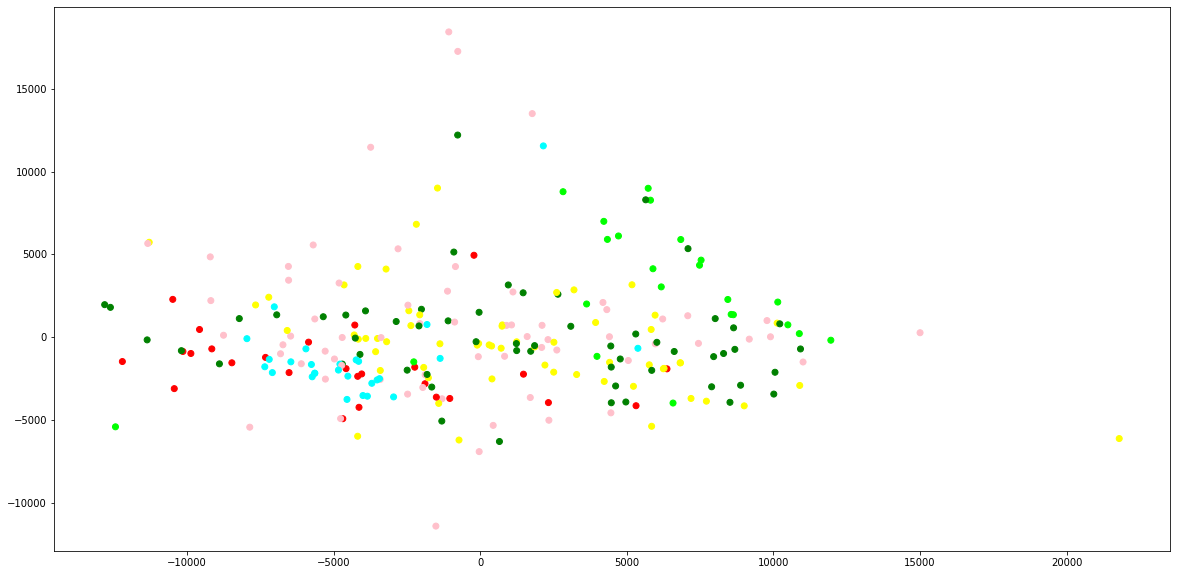

In [ ]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['pink','red','green','blue','yellow','lime','cyan'])

plt.figure(figsize=(20,10))
plt.scatter(dims[:,0],dims[:,1],c = labels,cmap = colors)
  # plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [ ]:
folder = 'kenya_jpeg/'

images = []
for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    img = np.array(img)
    images.append(img)
  



In [ ]:
np.asarray(images).shape

(259, 153, 153, 3)

## Scatter plot with Images 

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import annotate

def imscatter(x, y, labels,images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0,l in zip(x, y, images,labels):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        bc = annotate(str(l),(x0,y0),xycoords='data',c = colors[l],fontweight = "extra bold",fontsize = "xx-large")
        artists.append(ax.add_artist(ab))
        artists.append(ax.add_artist(bc))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

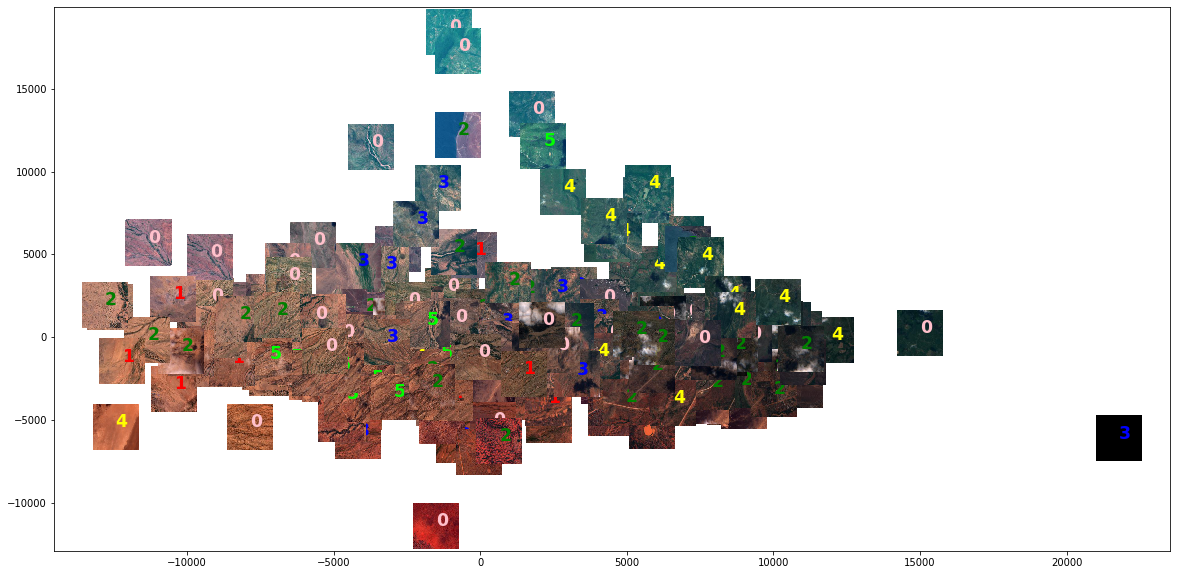

In [ ]:


colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
plt.figure(figsize=(20,10))
imscatter(dims[:,0],dims[:,1],labels,images)
plt.savefig("pre_text_kmeans_cls_6.jpg")

In [ ]:
pd.Series(labels).value_counts()

0    65
3    60
2    58
5    27
1    26
4    23
dtype: int64

In [ ]:
# np.save('pretext_kmeans_labels_6_cls',labels)

# step 5 : Trainig the SCAN Model.



In [ ]:
!python scan.py --config_env configs/env.yml --config_exp configs/scan/scan_kenya_custom_augmentation.yml 

{'setup': 'scan', 'train_dir': 'KenyaModel_6CLS_153_exp', 'criterion': 'scan', 'criterion_kwargs': {'entropy_weight': 7.0}, 'update_cluster_head_only': False, 'num_heads': 1, 'backbone': 'resnet18', 'train_db_name': 'KenyaDataset', 'num_classes': 6, 'num_neighbors': 5, 'augmentation_strategy': 'custom_aug', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.5, 1.0], 'ratio': [0.75, 1.3333]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': [0.5, 2], 'contrast': [2, 7], 'saturation': 0, 'hue': 0}, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'optimizer': 'sgd', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0, 'nesterov': False, 'momentum': 0.9}, 'epochs': 150, 'batch_size': 32, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './KenyaModel_6CLS_153_exp/pretext', 'pre

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch

train_dir = './KenyaModel_6CLS_153_exp'

path = train_dir + '/scan/model.pth.tar'

print('Model path : ',path)

state_dict = torch.load(path)

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 6, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()


Model path :  ./KenyaModel_6CLS_153_exp/scan/model.pth.tar


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:

#getting the config
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/scan/scan_kenya_custom_augmentation.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transforms)

loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


data_file = {'index':[],'pred':[]}

for idx,data in enumerate(loader):
  
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    data_file['index'].append(idx)

loading kenya dataset ....


In [ ]:
import pandas as pd
pred_df = pd.DataFrame(data_file)

pred_df['pred'].value_counts()

3    52
0    46
1    45
5    42
4    38
2    36
Name: pred, dtype: int64

In [ ]:
# pred_df.to_csv('SCAN_preds_5.csv',index = False)

In [ ]:
# colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
# plt.figure(figsize=(20,10))
# imscatter(dims[:,0],dims[:,1],pred_df['pred'].values,images)
# # plt.savefig("scan_labels.jpg")

## Creating 6 Folders. One for each cluster and then try to manually identify the cluster  (optional)

Classes = [ Annual Cropland,Perennial cropland,open grassland, wooded  grasslands, forestland, openwater,bare soil, otherland.]


## Creating  folders  : The output of each cluster will be saved in a seperate folder.

In [ ]:
!rm --r Pseudo\ Labels\ 6\ CLS\ 153\ exp\

In [ ]:
root = 'Pseudo Labels 6 CLS 153 exp'
os.mkdir(root)

In [ ]:
for i in range(6):
    os.mkdir(f'{root}/{i}')

In [ ]:


p = create_config('configs/env.yml','configs/scan/scan_kenya_custom_augmentation.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transform = None)


for idx,data in tqdm(enumerate(train_dataset)):

  
      trax_img = transforms(data['image'])

      folder_name = str(torch.argmax(model(trax_img.unsqueeze(dim = 0).cuda())[0],dim = 1).cpu().detach().numpy()[0])
      
      img_path = root + "/" + folder_name + f"/image_cluster_{folder_name}_{idx}.jpeg" 
  
      img = np.array(data['image'])
    
      plt.imsave(img_path,img)


      if idx == 258: break 
  







0it [00:00, ?it/s]





5it [00:00, 47.97it/s]

loading kenya dataset ....








10it [00:00, 48.09it/s]





16it [00:00, 37.43it/s]





22it [00:00, 41.87it/s]





28it [00:00, 45.99it/s]





35it [00:00, 50.19it/s]





40it [00:00, 44.28it/s]





47it [00:01, 49.26it/s]





53it [00:01, 49.41it/s]





59it [00:01, 39.20it/s]





66it [00:01, 44.59it/s]





73it [00:01, 49.54it/s]





79it [00:01, 39.23it/s]





87it [00:01, 45.38it/s]





94it [00:02, 50.33it/s]





100it [00:02, 39.01it/s]





108it [00:02, 45.14it/s]





115it [00:02, 39.40it/s]





122it [00:02, 45.07it/s]





130it [00:02, 50.81it/s]





136it [00:03, 41.65it/s]





143it [00:03, 47.05it/s]





151it [00:03, 52.58it/s]





158it [00:03, 42.40it/s]





165it [00:03, 48.02it/s]





172it [00:03, 40.84it/s]





179it [00:03, 46.12it/s]





186it [00:04, 51.26it/s]





192it [00:04, 40.56it/s]





200it [00:04, 46.60it/s]





207it [00:04, 51.55it/s]





213it [00:04, 40.61it/s]





220it [00:04, 46.07it/s]





226it [00:04, 38.32it/s]





234it [00:05, 44.4

# Plotting all the Clusters 

In [ ]:
import torch
from torchvision.utils import make_grid
from PIL import Image

#helper function. 
def plot_clusters(root,cluster):

   folder = root + f"/{cluster}/"
   
   print(folder)

   print('no. of images : ',len(os.listdir(folder)))

   images = []
   for  img_name in  os.listdir(folder):
            image_path = folder + img_name 
            # print(img_name)
            img = Image.open(image_path)
            images.append(np.transpose(np.array(img),(2,0,1)))
    
   
   

   grid = make_grid(torch.tensor(images),nrow = 8)
  #  print(grid.shape)
   plt.figure(figsize=(10,10)) 
   plt.imshow(np.transpose(grid,(1,2,0)))
   plt.savefig(root + f"/cluster__{cluster}.jpg")


Pseudo Labels 6 CLS 153 exp/0/
no. of images :  46


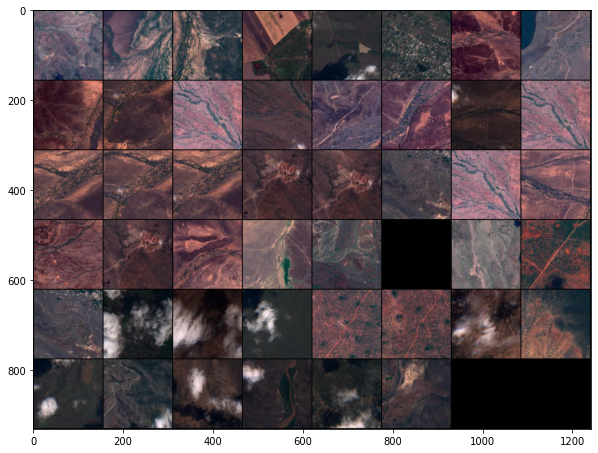

In [ ]:
plot_clusters(root,0)

Pseudo Labels 6 CLS 153 exp/1/
no. of images :  45


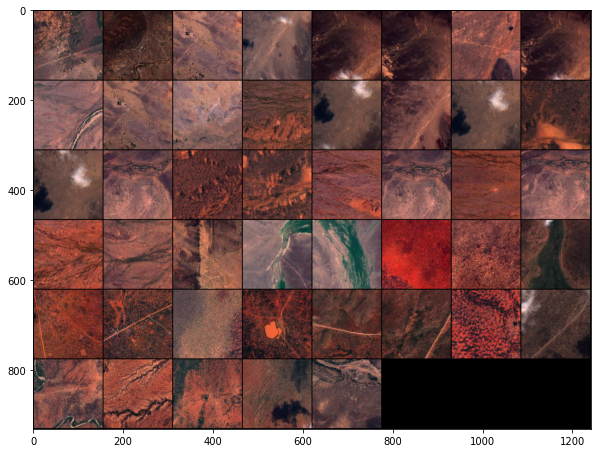

In [ ]:
plot_clusters(root,1)

Pseudo Labels 6 CLS 153 exp/2/
no. of images :  36


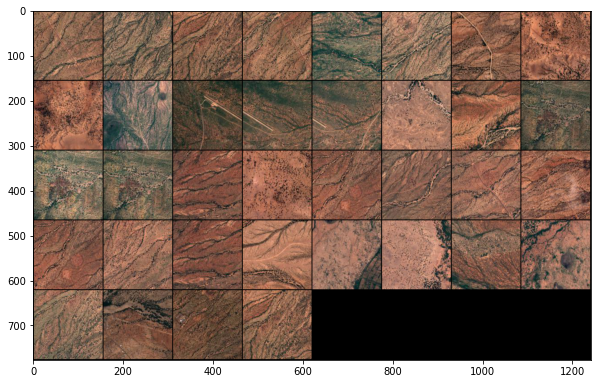

In [ ]:
plot_clusters(root,2)

Pseudo Labels 6 CLS 153 exp/3/
no. of images :  52


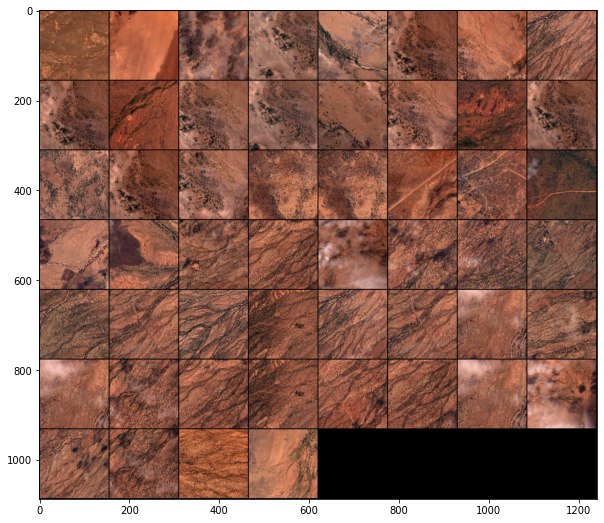

In [ ]:
plot_clusters(root,3)

Pseudo Labels 6 CLS 153 exp/4/
no. of images :  38


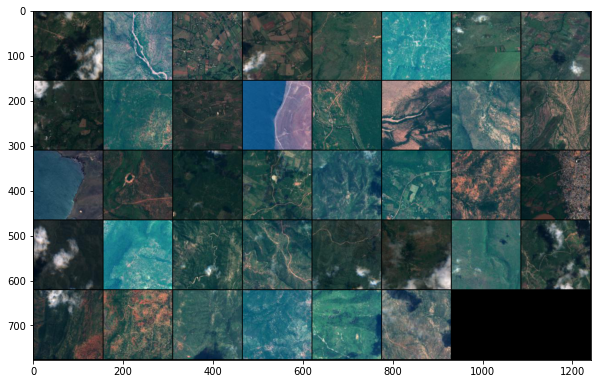

In [ ]:
plot_clusters(root,4)

Pseudo Labels 6 CLS 153 exp/5/
no. of images :  42


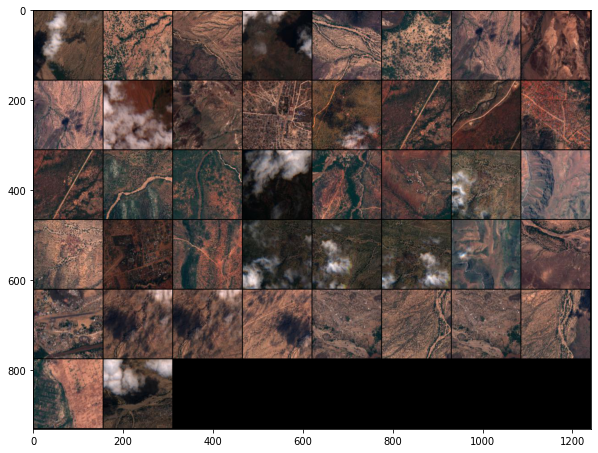

In [ ]:
plot_clusters(root,5)

# 6 : Training the self-label model

In [ ]:
!python selflabel.py --config_env configs/env.yml --config_exp configs/selflabel/selflabel_kenya_custom_augmentation.yml 

{'setup': 'selflabel', 'train_dir': 'KenyaModel_6CLS_153_exp', 'confidence_threshold': 0.99, 'use_ema': False, 'ema_alpha': 0.999, 'criterion': 'confidence-cross-entropy', 'criterion_kwargs': {'apply_class_balancing': False}, 'backbone': 'resnet18', 'num_heads': 1, 'train_db_name': 'KenyaDataset', 'num_classes': 6, 'augmentation_strategy': 'custom_aug', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.5, 1.0], 'ratio': [0.75, 1.3333]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': [0.5, 2], 'contrast': [2, 7], 'saturation': 0, 'hue': 0}, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4049, 0.309, 0.2831], 'std': [0.2702, 0.1792, 0.1679]}}, 'optimizer': 'sgd', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0, 'nesterov': False, 'momentum': 0.9}, 'epochs': 50, 'batch_size': 32, 'num_workers': 8, 'scheduler': 'constant', 'pretext_d

In [ ]:
!rm --r Pseudo\ Labels\ 6\ CLS\ 153\ exp\ selflabel
root = 'Pseudo Labels 6 CLS 153 exp selflabel'
os.mkdir(root)
for i in range(6):
    os.mkdir(f'{root}/{i}')

In [ ]:
from torchvision.utils import make_grid
from PIL import Image
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch


train_dir = './KenyaModel_6CLS_153_exp'

path = train_dir + '/selflabel/model.pth.tar'

print('Model path : ',path)

state_dict = torch.load(path)

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 6, 1)
model.load_state_dict(state_dict)
model = model.cuda()
model.eval()


Model path :  ./KenyaModel_6CLS_153_exp/selflabel/model.pth.tar


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/selflabel/selflabel_kenya_custom_augmentation.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transform = None)


for idx,data in tqdm(enumerate(train_dataset)):

  
      trax_img = transforms(data['image'])

      folder_name = str(torch.argmax(model(trax_img.unsqueeze(dim = 0).cuda())[0],dim = 1).cpu().detach().numpy()[0])
      
      img_path = root + "/" + folder_name + f"/image_cluster_{folder_name}_{idx}.jpeg" 
  
      img = np.array(data['image'])
    
      plt.imsave(img_path,img)


      if idx == 258: break 
  










0it [00:00, ?it/s]








3it [00:00, 15.76it/s]

loading kenya dataset ....











9it [00:00, 19.98it/s]








15it [00:00, 24.68it/s]








21it [00:00, 29.95it/s]








25it [00:00, 26.03it/s]








32it [00:00, 31.46it/s]








39it [00:00, 37.23it/s]








44it [00:01, 31.47it/s]








51it [00:01, 36.92it/s]








58it [00:01, 41.88it/s]








64it [00:01, 35.06it/s]








71it [00:01, 41.03it/s]








78it [00:01, 46.29it/s]








84it [00:01, 46.63it/s]








91it [00:02, 51.69it/s]








99it [00:02, 56.25it/s]








106it [00:02, 44.56it/s]








114it [00:02, 50.10it/s]








122it [00:02, 42.76it/s]








129it [00:02, 48.05it/s]








136it [00:02, 52.93it/s]








142it [00:03, 41.02it/s]








150it [00:03, 46.98it/s]








157it [00:03, 51.11it/s]








163it [00:03, 40.16it/s]








170it [00:03, 46.03it/s]








177it [00:03, 50.82it/s]








183it [00:03, 47.62it/s]








190it [00:04, 52.58it/s]








196it [00:04, 46.06it/s]








202it [00:04, 36.68it/s]








208it [00:04, 41.

Pseudo Labels 6 CLS 153 exp selflabel/0/
no. of images :  36


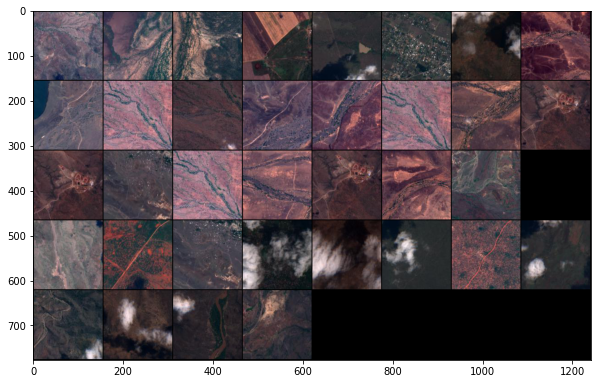

In [ ]:
plot_clusters(root,0)

Pseudo Labels 6 CLS 153 exp selflabel/1/
no. of images :  58


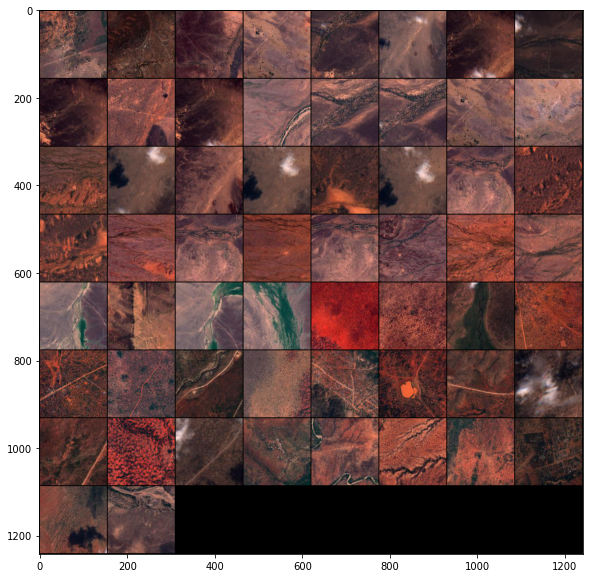

In [ ]:
plot_clusters(root,1)

Pseudo Labels 6 CLS 153 exp selflabel/2/
no. of images :  33


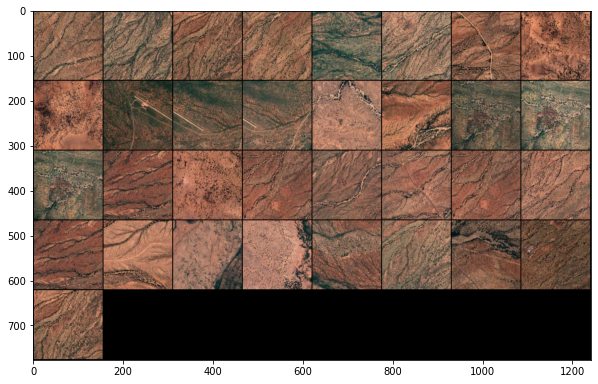

In [ ]:
plot_clusters(root,2)

Pseudo Labels 6 CLS 153 exp selflabel/3/
no. of images :  53


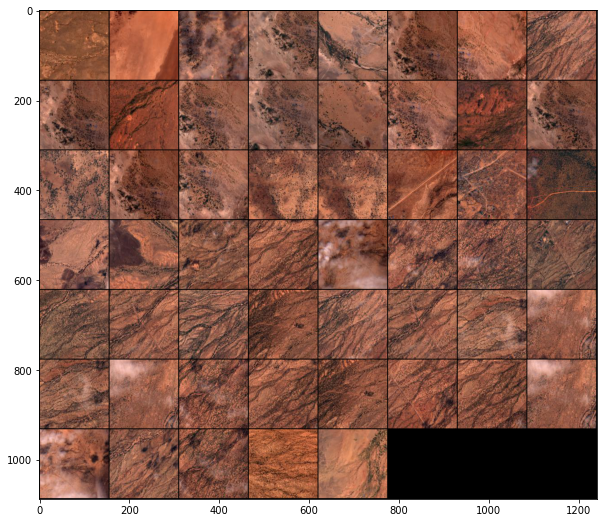

In [ ]:
plot_clusters(root,3)

Pseudo Labels 6 CLS 153 exp selflabel/4/
no. of images :  36


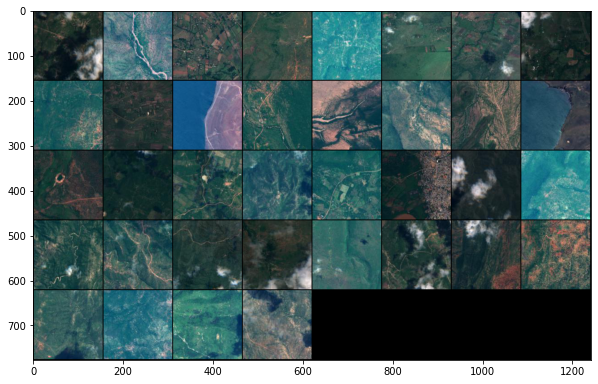

In [ ]:
plot_clusters(root,4)

Pseudo Labels 6 CLS 153 exp selflabel/5/
no. of images :  43


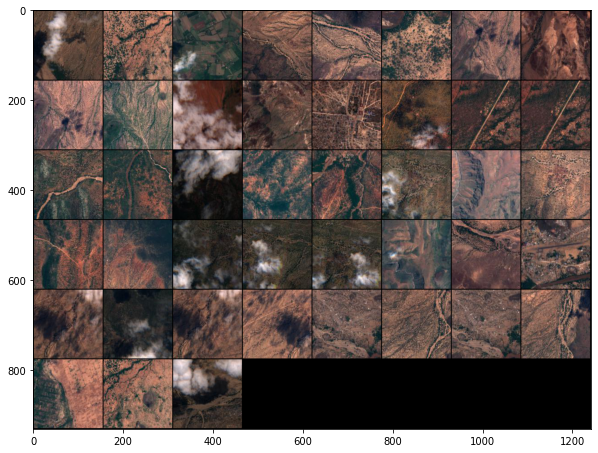

In [ ]:
plot_clusters(root,5)

# 7: Valiadting using Histograms 

## Steps to follow. 
1. get the x,y files from the tiff images one per cluster. 
2. get the labels and color values
3. plot the histograms 

In [ ]:
!pip install rasterio

In [ ]:
#step 1 
from IPython.display import display
import re
import pandas as pd 
import os
from tqdm import tqdm 
import rasterio as rio
from rasterio.plot import show

def get_xy_cordinates(cluster_path):

  #xy stores all points
  xy = []

  # since the clustr_folder contains jpeg images we need to map those to tiff. images
  cluster_data = list(map(lambda x :'kenya_tiff/image_'+re.findall('\d+',x)[-1]+".tif" if 'jpeg' in x else x,os.listdir(cluster_path)))

  for img_path in cluster_data:
          # print(img_path)
          raster = rio.open(img_path)
          bottom = raster.bounds[1]
          right = raster.bounds[2]    
          xy.append((right,bottom))

  return xy   
 
# img_path = '../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/Kenya_AOI_before_224_clean/'
# x,y = getXYCordinates(img_path)



In [ ]:
#step 2 
from osgeo import gdal
import sys
import csv

colorCoding = { '0':'unknown',
                '20':'shrubland',
                '30':'herbaceous_vegetation',
                '40':'cropland',
                '50':'built-up',
                '60':'bare_sparse_vegetation',
                '70':'snow_ice',
                '80':'permanent_inland_water',
                '90':'herbaceous_wetland',
                '100':'moss_lichen',
                '111':'ENF_closed',
                '112':'EBF_closed',
                '113':'DNF_closed',
                '114':'DBF_closed',
                '115':'mixed _closed',
                '116':'unknown_closed',
                '121':'ENF_open',
                '122':'EBF_open',
                '123':'DNF_open',
                '124':'DBF_open',
                '125':'mixed _open',
                '126':'unknown_open',
                '200':'sea'}


# coordinates to get pixel values for (as tuples of points)

# open the raster file

def get_labeled_csv(root_tiff,cluster_folder,save_folder):


    ds = gdal.Open(root_tiff)

    if ds is None:
        print('Could not open the raster file')
        sys.exit(1)
    else:
        print('The raster file was opened satisfactorily')

    # get georeference info
    transform = ds.GetGeoTransform() 
    xOrigin = transform[0]
    yOrigin = transform[3] 
    pixelWidth = transform[1]
    pixelHeight = transform[5] 

    band = ds.GetRasterBand(1) # 1-based index

    data = band.ReadAsArray()


    for root,clusters,_ in os.walk(cluster_folder):

        for cluster in clusters:
            print("Getting x,y pts for cluster ",cluster)
            points = get_xy_cordinates(os.path.join(root,cluster))

            if not os.path.exists(save_folder):
                os.mkdir(save_folder)

            save_file = save_folder + "/labeled_" + cluster +".csv"
            print(f'saving results for cluster {cluster} in file {save_file}')
            # loop through the coordinate
            with open(save_file, 'w', newline='') as outf:
                writer = csv.writer(outf)
                row_new = ['lat', 'long', 'pixel_value', 'label'] 
                writer.writerow(row_new)
                for point in points:
                    x = point[0]
                    y = point[1]

                    xOffset = int((x - xOrigin) / pixelWidth)
                    yOffset = int((y - yOrigin) / pixelHeight)
                    #print(xOffset)
                    #print(yOffset)
                    # get individual pixel values
                    
                    value = int(np.median(data[yOffset:yOffset+153,xOffset:xOffset+153]))
                    label = colorCoding[str(value)]
                    # print(value, label)
                    row_new = [x, y, value, label]
                    writer.writerow(row_new)


### PLotting the LandCoverClasses.tiff file

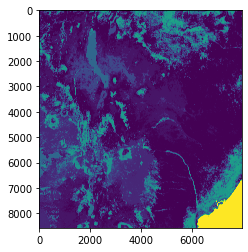

In [ ]:
img = rio.open('LandCoverClasses.tif').read()
show(img)


In [ ]:
!pwd

In [ ]:
#only using output of of the scan model.

root_tiff = 'LandCoverClasses.tif'
cluster_folder = 'Pseudo Labels 6 CLS 153 exp selflabel'
save_folder = 'Cluster_Labels_6_153_exp_selflabel'

get_labeled_csv(root_tiff,cluster_folder,save_folder)

The raster file was opened satisfactorily
Getting x,y pts for cluster  0
saving results for cluster 0 in file Cluster_Labels_6_153_exp_selflabel/labeled_0.csv
Getting x,y pts for cluster  1
saving results for cluster 1 in file Cluster_Labels_6_153_exp_selflabel/labeled_1.csv
Getting x,y pts for cluster  2
saving results for cluster 2 in file Cluster_Labels_6_153_exp_selflabel/labeled_2.csv
Getting x,y pts for cluster  3
saving results for cluster 3 in file Cluster_Labels_6_153_exp_selflabel/labeled_3.csv
Getting x,y pts for cluster  4
saving results for cluster 4 in file Cluster_Labels_6_153_exp_selflabel/labeled_4.csv
Getting x,y pts for cluster  5
saving results for cluster 5 in file Cluster_Labels_6_153_exp_selflabel/labeled_5.csv


In [ ]:
# step 3 plotting histogram 
import collections
import matplotlib.pyplot as plt


covers = ['unknown', 
          'shrubland', 
          'herbaceous_vegetation',
          'cropland', 
          'built-up',
          'bare_sparse_vegetation',
          'snow_ice',
          'permanent_inland_water',
          'herbaceous_wetland',
          'moss_lichen',
          'ENF_closed',
          'EBF_closed',
          'DNF_closed',
          'DBF_closed',
          'mixed _closed',
          'unknown_closed',
          'ENF_open',
          'EBF_open',
          'DNF_open',
          'DBF_open',
          'mixed _open',
          'unknown_open',
          'sea']


def plot_histograms(csv_file):

      veg_covers = []
      with open(csv_file) as inf:
          reader = csv.reader(inf)
          isHeading = False
          for row in reader:
              if isHeading: 
                  # print(row) 
                  veg_covers.append(row[3])
              isHeading = True 

      
      c = collections.Counter(veg_covers)
      c = sorted(c.items()) 
      veg_names = [i[0] for i in c]
      freq = [i[1] for i in c]


      cluster = csv_file.strip().split('.')[0][-1]

      print(f"cluster {cluster}", c)
      f, ax = plt.subplots()

      plt.bar(veg_names, freq, color=['violet', 'red', 'yellow', 'green', 'blue', 'cyan','black'], edgecolor='black')
      plt.title("Per cluster Distribution")
      plt.xlabel("Vegetation")
      plt.ylabel("Frequency")
      ax.set_xticks(range(0, len(veg_names)))
      ax.set_xticklabels(veg_names)
      f.autofmt_xdate()
      img_file = csv_file.replace('csv','jpeg')
      plt.savefig(img_file)
      plt.show()
      


cluster 0 [('EBF_closed', 1), ('bare_sparse_vegetation', 6), ('cropland', 1), ('herbaceous_vegetation', 11), ('shrubland', 14), ('unknown_closed', 2), ('unknown_open', 1)]


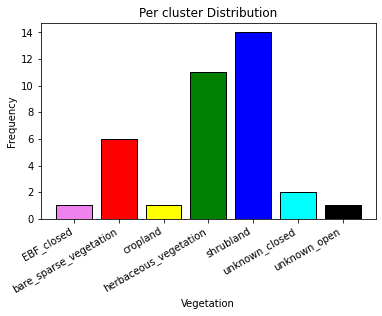

cluster 1 [('bare_sparse_vegetation', 23), ('herbaceous_vegetation', 10), ('shrubland', 25)]


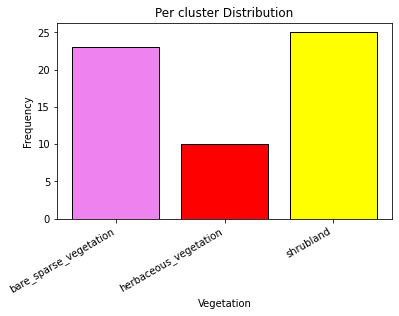

cluster 2 [('bare_sparse_vegetation', 5), ('herbaceous_vegetation', 20), ('shrubland', 5), ('unknown_closed', 3)]


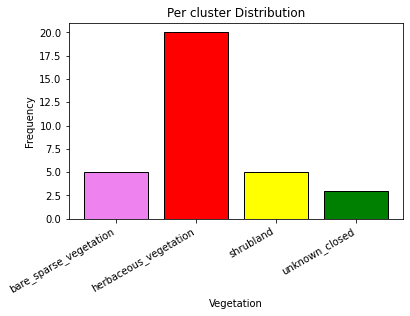

cluster 3 [('bare_sparse_vegetation', 21), ('herbaceous_vegetation', 29), ('shrubland', 3)]


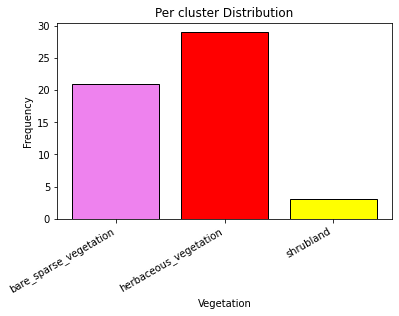

cluster 4 [('EBF_closed', 1), ('bare_sparse_vegetation', 1), ('cropland', 5), ('herbaceous_vegetation', 4), ('shrubland', 16), ('unknown_closed', 4), ('unknown_open', 5)]


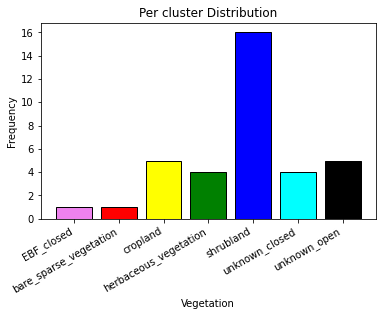

cluster 5 [('bare_sparse_vegetation', 6), ('cropland', 1), ('herbaceous_vegetation', 14), ('shrubland', 17), ('unknown_closed', 5)]


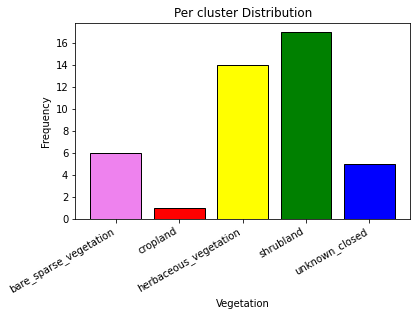

In [ ]:
# plotting for all clusters 

save_folder = 'Cluster_Labels_6_153_exp_selflabel'

csv_file = '{}/labeled_{}.csv'


for i in range(6):
    plot_histograms(csv_file.format(save_folder,i))

